In [47]:
# load the necessary packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

import itertools

import os
import numpy as np
import matplotlib.pyplot as plt

### Load Data and Model

In [2]:
batch_size = 100
IMG_HEIGHT = 180
IMG_WIDTH = 180
test_dir = 'data/resized/test'
dropout_rate = 0.15

In [3]:
test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                          directory=test_dir,
                                                          shuffle=False,
                                                          target_size=(IMG_HEIGHT,IMG_WIDTH))

Found 25250 images belonging to 101 classes.


In [4]:
test_data_gen.samples

25250

In [102]:
# load up saved model
model = load_model('tmp/models/CNN_MODEL_V1.h5')

In [8]:
probabilities = model.predict_generator(test_data_gen,
                                        steps=25250//batch_size + 1)

In [9]:
y_pred = np.argmax(probabilities, axis=1)
len(y_pred)

25250

In [104]:
y_test = test_data_gen.classes
y_test

array([  0,   0,   0, ..., 100, 100, 100])

In [112]:
# initialize class names
class_names = []
for key in test_data_gen.class_indices.keys():
    class_names.append(key)

### Get stats on prediction per class

In [114]:
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=class_names))

Classification Report
                         precision    recall  f1-score   support

              apple_pie       0.12      0.25      0.16       250
         baby_back_ribs       0.46      0.34      0.39       250
                baklava       0.47      0.42      0.44       250
         beef_carpaccio       0.57      0.59      0.58       250
           beef_tartare       0.35      0.29      0.32       250
             beet_salad       0.51      0.22      0.30       250
               beignets       0.54      0.65      0.59       250
               bibimbap       0.77      0.54      0.64       250
          bread_pudding       0.18      0.21      0.19       250
      breakfast_burrito       0.09      0.11      0.10       250
             bruschetta       0.38      0.19      0.25       250
           caesar_salad       0.71      0.35      0.47       250
                cannoli       0.41      0.36      0.38       250
          caprese_salad       0.33      0.34      0.34       250
  

### Plot confusion Matrix

In [115]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 63   1   8 ...   7   0   6]
 [  0  85   1 ...   2   1   3]
 [ 24   0 105 ...   1   0   1]
 ...
 [ 16   0   2 ... 125   0   1]
 [  0   3   1 ...   0  58   0]
 [ 12   3   1 ...   3   1 117]]


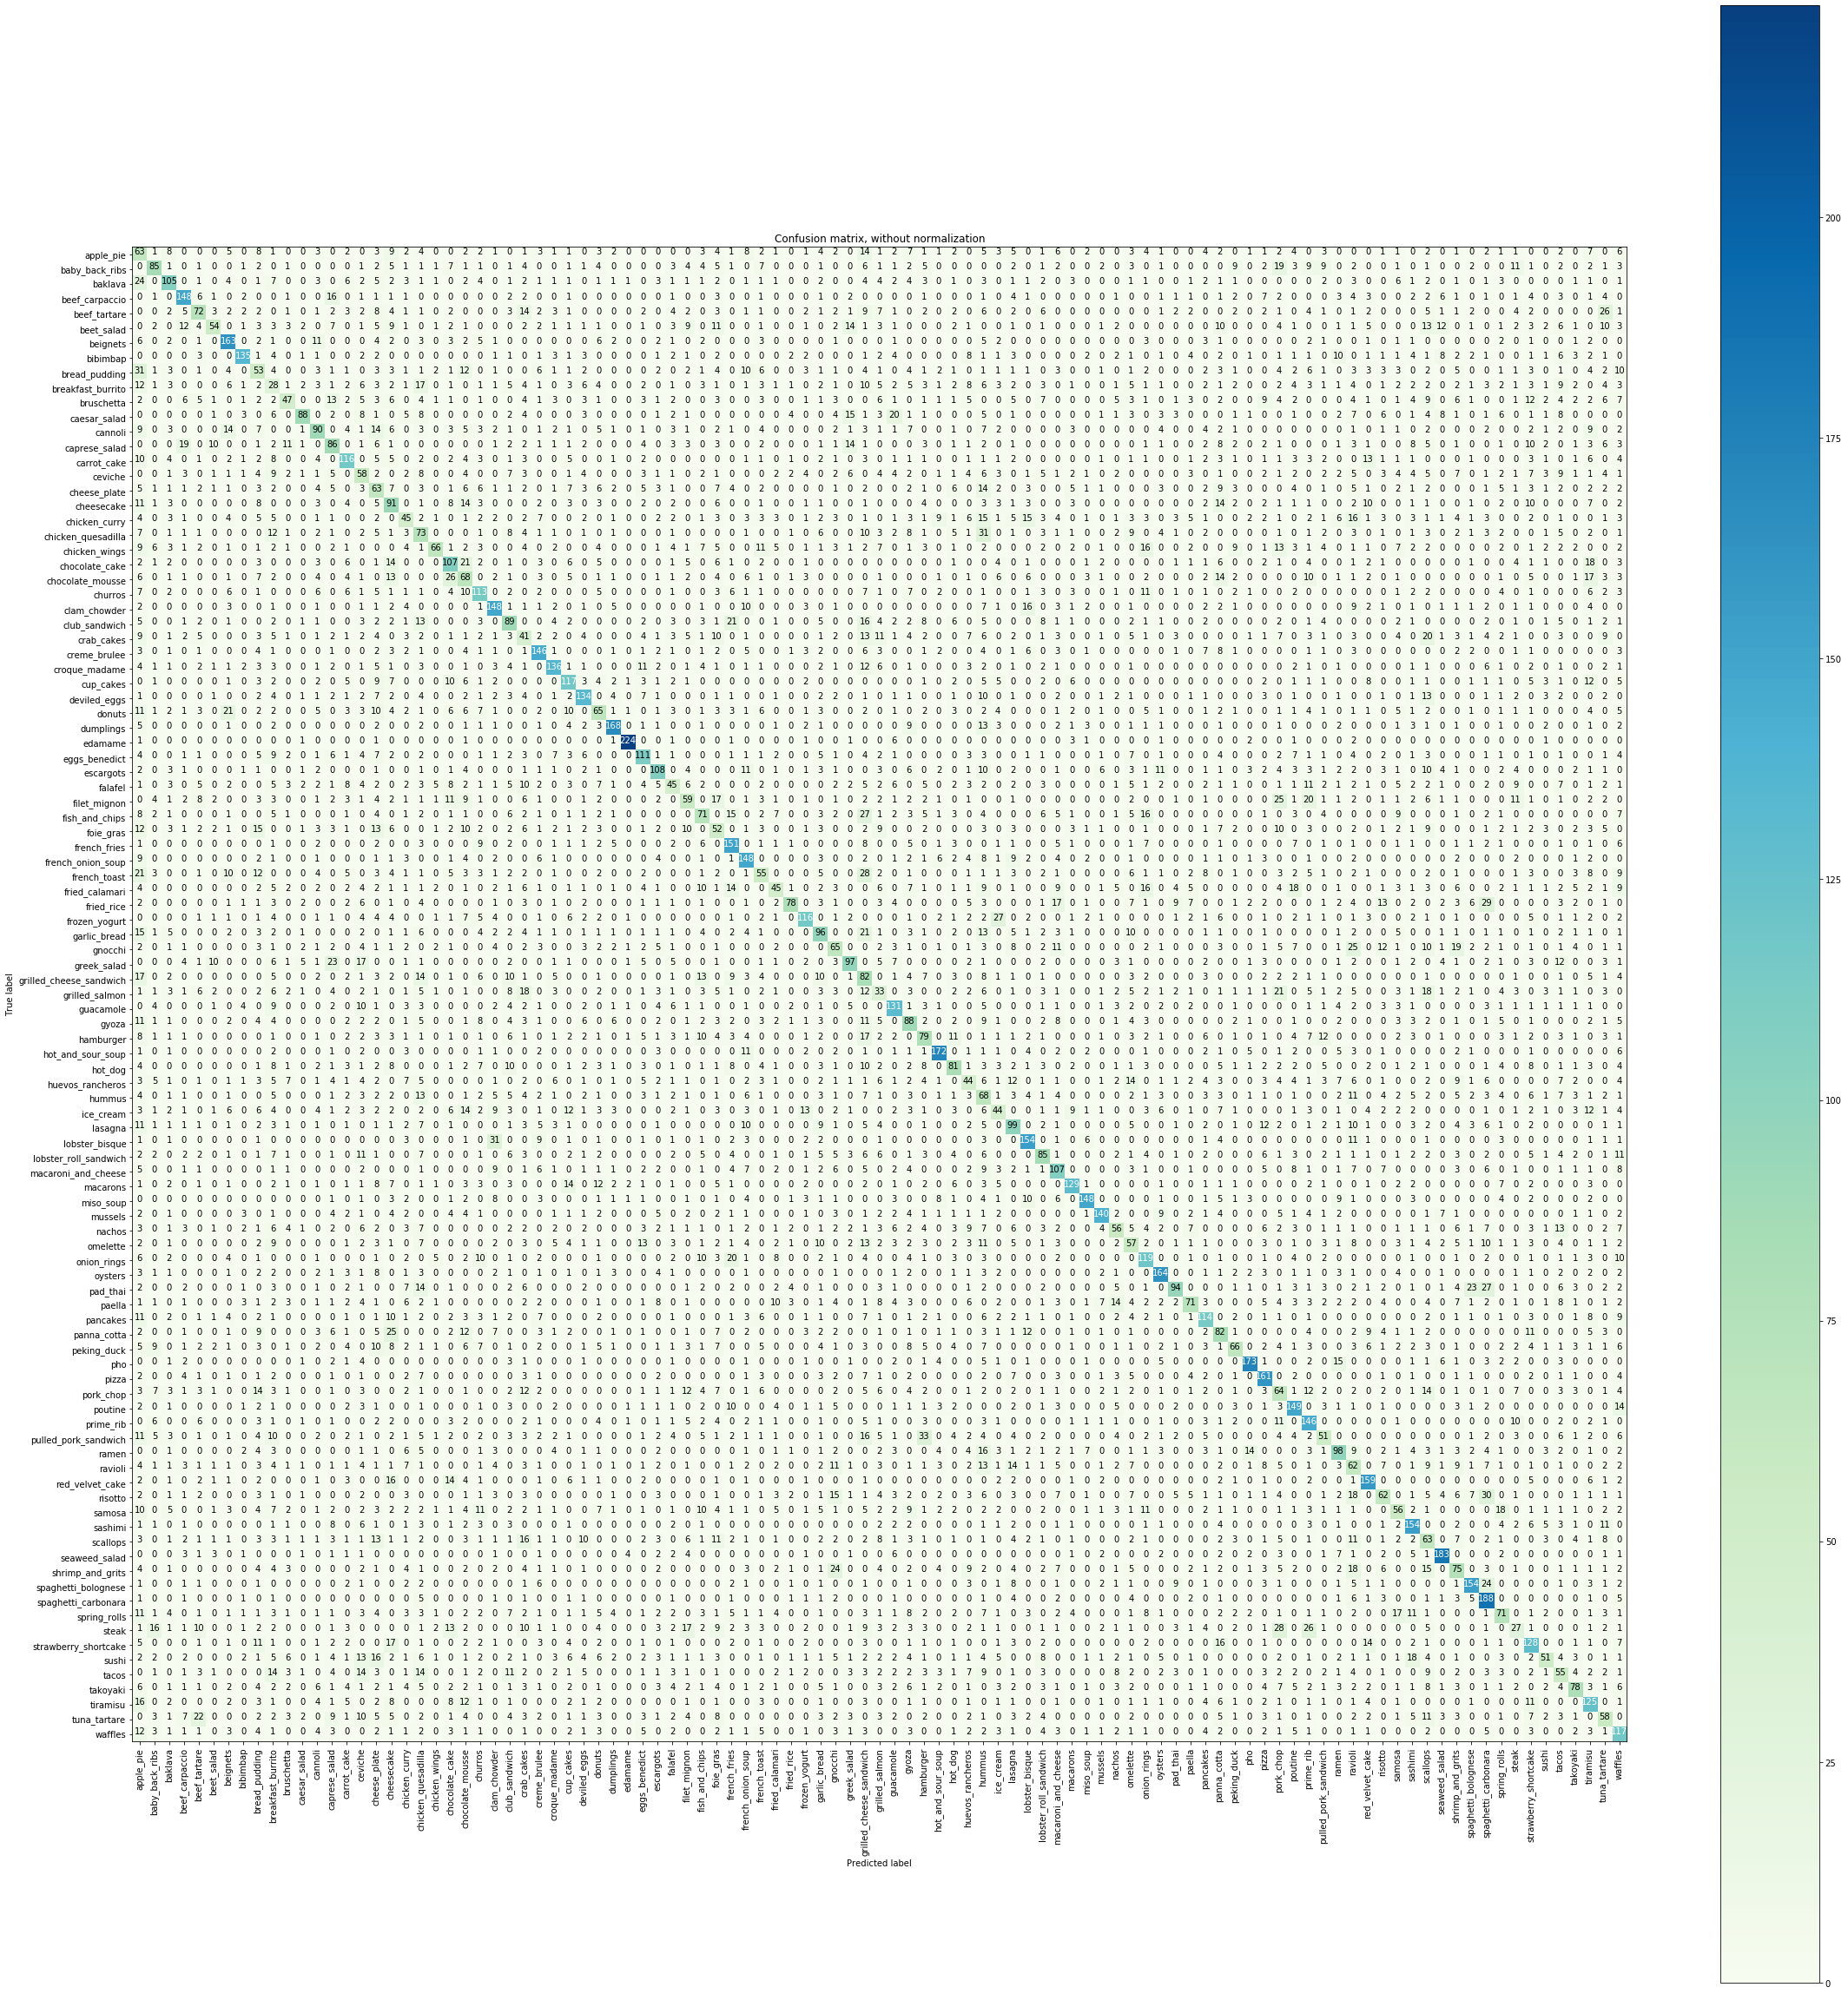

In [116]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.GnBu)
plt.show()

In [117]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [118]:
auc = multiclass_roc_auc_score(y_test, y_pred)
print("Multi-Class AUC Score is: {}".format(auc))

Multi-Class AUC Score is: 0.6909400000000001


In [119]:
def show_images_prediction(food_class,y_test, page=0):
    page_size = 20
    nrows = 4
    ncols = 5
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    fig.set_size_inches(12, 8)
    fig.tight_layout()
    start_i = (class_names.index(food_class) * 250) + (page * 20)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(plt.imread(test_data_gen.filepaths[i+start_i]))
        ax.set_axis_off()
        ax.title.set_visible(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
        predicted = class_names[y_pred[i+start_i]]
        match = predicted ==  class_names[y_test[start_i + i]]
        ec = (1, .5, .5)
        fc = (1, .8, .8)
        if match:
            ec = (0, .6, .1)
            fc = (0, .7, .2)
        # predicted label
        ax.text(0, 140, 'P: ' + predicted, size=10, rotation=0,
            ha="left", va="top",
             bbox=dict(boxstyle="round",
                   ec=ec,
                   fc=fc,
                   )
             )
        if not match:
            # true label
            ax.text(0, 170, 'A: ' + class_names[y_test[start_i + i]], size=10, rotation=0,
                ha="left", va="top",
                 bbox=dict(boxstyle="round",
                       ec=ec,
                       fc=fc,
                       )
                 )
    plt.subplots_adjust(left=0, wspace=1, hspace=0)
    plt.show()

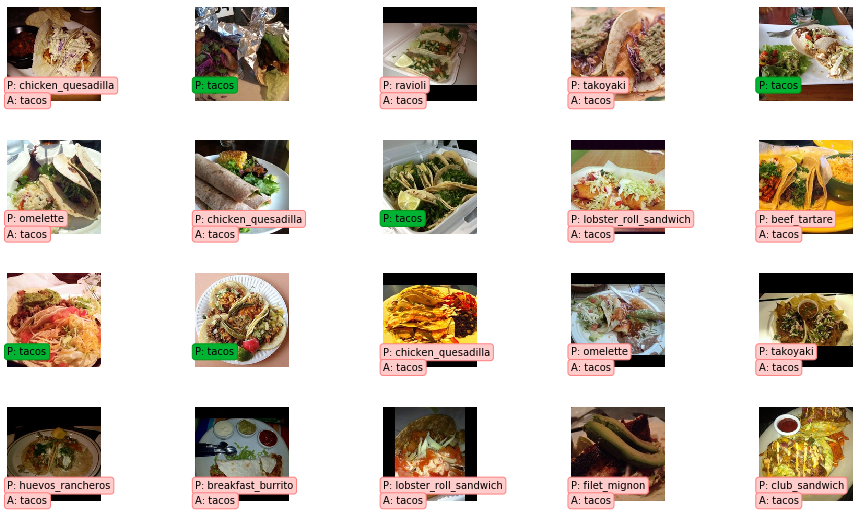

In [121]:
show_images_prediction('tacos', y_test, page=1)